# 0 - Quick Imports

In [3]:
import numpy as np
import PIL
from PIL import Image
import numpy as np
import torch
import os
import sys

sys.path.append('..')
os.chdir('..')
print(os.getcwd()) # confirm the working directory is the repo root

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/jas/project/alphagen
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

# 1 - Flux + NegToMe

In [3]:
from src.negtome.pipeline_negtome_flux import FluxNegToMePipeline
pipe = FluxNegToMePipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda:3")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.5.1+cu121 with CUDA 1201 (you have 2.4.1)
    Python  3.11.10 (you have 3.11.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


using prompt: a high resolution photo of a person

use_negtome: False


  0%|          | 0/25 [00:00<?, ?it/s]

use_negtome: False
Time taken: 30.62 seconds


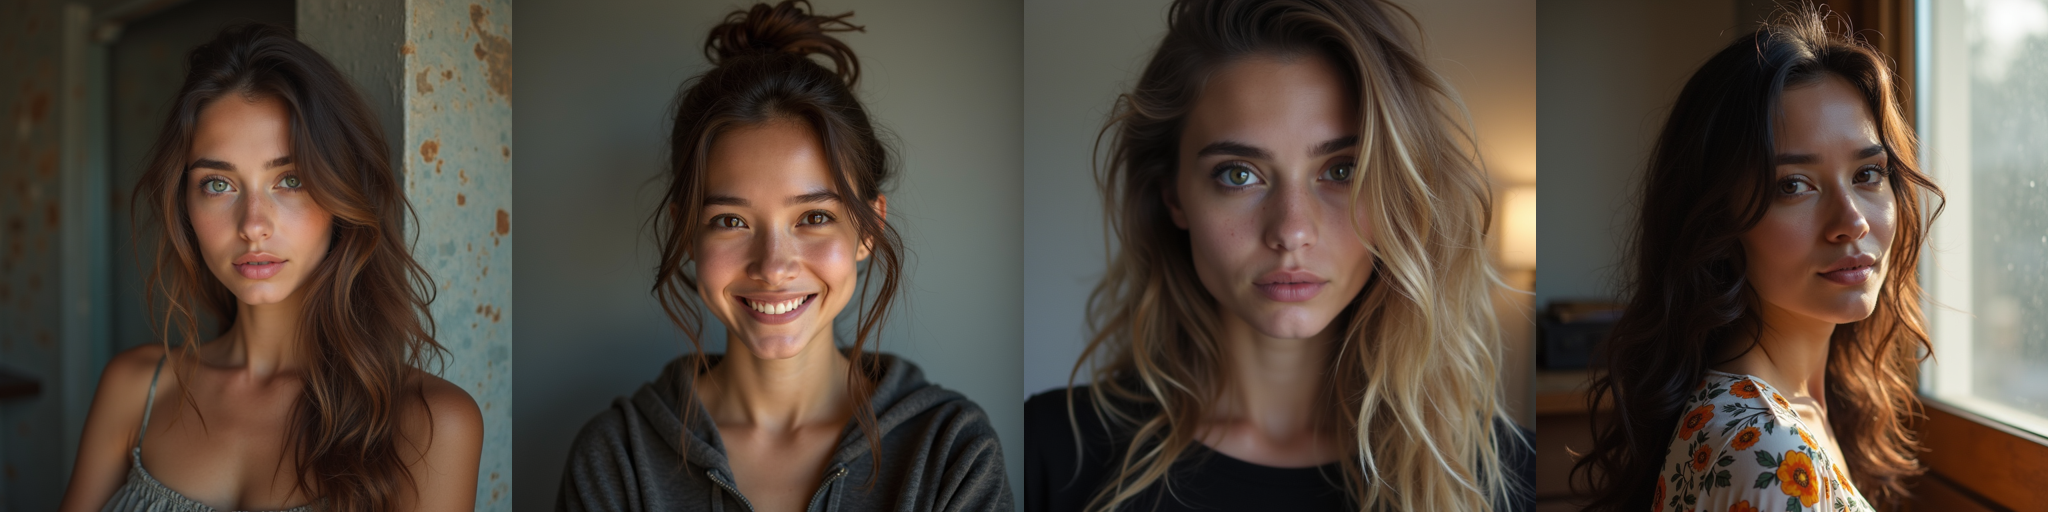


use_negtome: True


  0%|          | 0/25 [00:00<?, ?it/s]

use_negtome: True
Time taken: 31.71 seconds


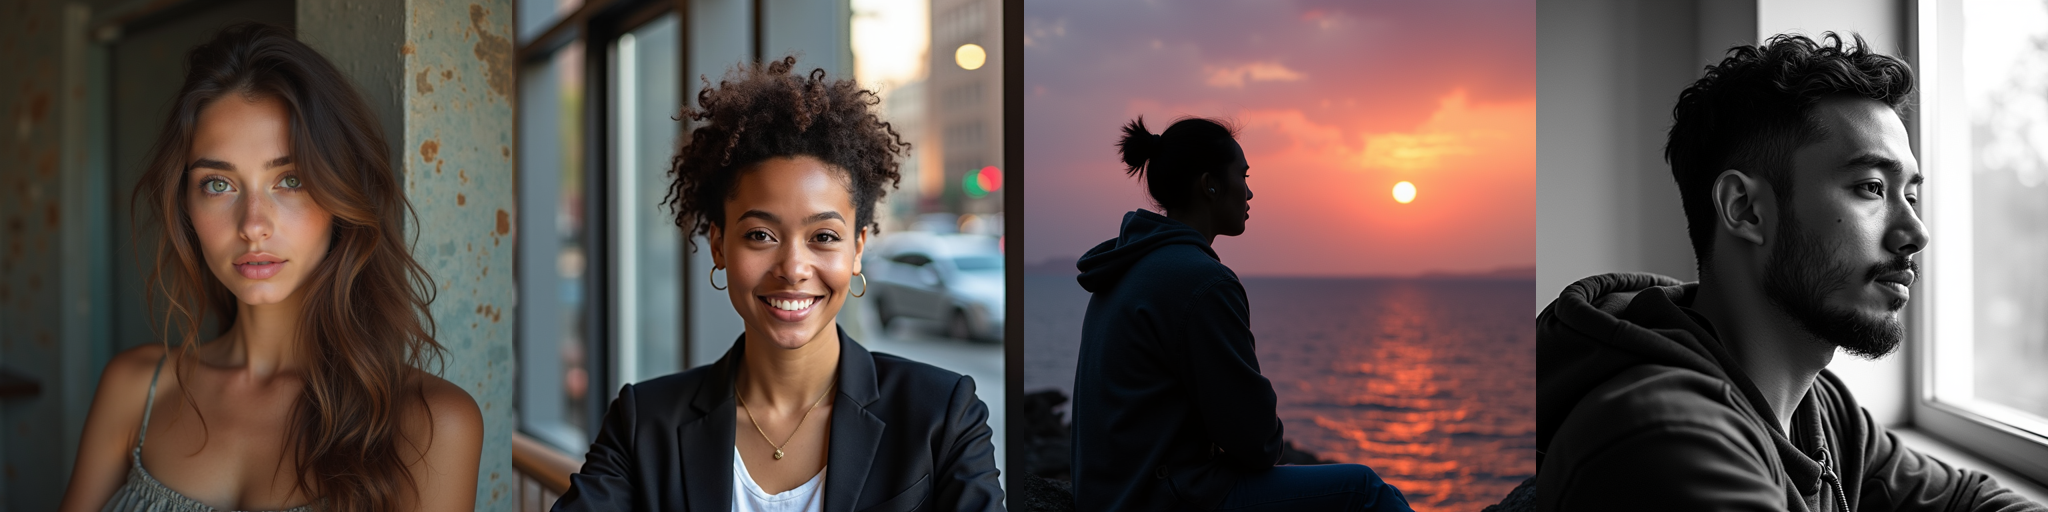


Percentage increase in inference time with negtome: 3.55%


In [9]:
from diffusers.utils import logging
logging.set_verbosity_error()  # only show errors not warnings: https://huggingface.co/docs/diffusers/en/api/logging
import time

negtome_args = {
    'use_negtome': False,
    'merging_alpha': 0.9,
    'merging_threshold': 0.65,
    'merging_dropout': 0.,
    'merging_t_start': 1000,
    'merging_t_end': 900,
    'num_joint_blocks': -1, # number of joint transformer blocks (flux) to apply negtome
    'num_single_blocks': -1, # number of single transformer blocks (flux) to apply negtome
}

# input prompt 
prompt = "a high resolution photo of a person"
print (f"using prompt: {prompt}")

# hyperparameters
seed = 0 
num_inference_steps = 25
num_images_per_prompt = 4 # generate 4 images across the batch
height = width = 768 

# generate both with and w/o negtome
inference_times = []
for use_negtome in [False, True]:
    print(f"\nuse_negtome: {use_negtome}")
    generator = torch.Generator(pipe.device).manual_seed(seed)
    
    # Measure time
    start_time = time.time()
    images = pipe(
        prompt=prompt,
        guidance_scale=3.5,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        generator=generator,
        num_images_per_prompt=num_images_per_prompt,
        use_negtome=use_negtome,
        negtome_args=negtome_args,
    ).images
    elapsed_time = time.time() - start_time
    inference_times.append(elapsed_time)
    
    print(f"use_negtome: {use_negtome}\nTime taken: {elapsed_time:.2f} seconds")
    display(display_alongside_batch(images, resize_dims=512))

# Calculate percentage increase
percentage_increase = ((inference_times[1] - inference_times[0]) / inference_times[0]) * 100
print(f"\nPercentage increase in inference time with negtome: {percentage_increase:.2f}%")

**Note**: As seen above, NegToMe leads to significant increase in output diversity (eg, racial: woman second image, gender: man last image, pose: third image, photo style: black and white photo last image, background: second, third image) etc, while only using <4% higher inference times.